### Check to see if tensorflow sees the GPU on your computer<br>
If it gives as output: [] than it means that it doesn't see the GPU. The whole code can be run even without the GPU, but don't run the CNN, use the weights (best_cnn_weights_acc45.h5) placed in the images folder.<br>
Don't try to run this code in google collab's free version, it won't pass the third box because of a lack of RAM.

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

### Imports of most of the libraries we are going to use<br>
It will just import some libraries, if it gives any error, check that you have this libraries downloaded.

In [1]:
from pathlib import Path 
from PIL import Image

import pandas as pd
import numpy as np   
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

### First step to build the dataframe<br>
The code below is used to take the path to the images from the folder were they are contained(patternmind_dataset, remeber to change the *DATA_ROOT* based on your PC), it opens them and transforms them in numpy arrays. It also check for the label of the image and put them toghether in the empty list *rows*, so that every image has its label.<br> 
There's also a check for the dimensions of the image: images over 500 pixel or under 100 pixels of height or width won't put in *rows*.<br>
The choice for the size of the images was taken arbitrarily to remove images that were too big or too small for the next resize.

In [ ]:
DATA_ROOT = Path('C:\\Users\\computer\\Documents\\Visual Studio Code\\patternmind_dataset')
MIN_SIZE = 100
MAX_SIZE = 500

rows = []

for class_dir in sorted(DATA_ROOT.iterdir()):
    if not class_dir.is_dir():
        continue
    label = class_dir.name

    for img_path in class_dir.glob("*.jpg"):
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        if h < MIN_SIZE or h > MAX_SIZE or w < MIN_SIZE or w > MAX_SIZE:
            continue
        img = img.resize((224,224), Image.BILINEAR)
        arr = np.array(img, dtype='float32') #necessario perchè tf vuole array
        rows.append((label, arr))


### Save cache file<br>
This code below is only needed to save the pre-processing done before, so that if the kernel has been restarted or the code closed, having the file with the cache will make you skip the previous box.<br>
Remeber to set the path where you want to put the file.

In [ ]:
SAVE_PATH = Path('C:\\Users\\computer\\Documents\\Visual Studio Code\\patternmind_cache.npz')
labels = np.array([r[0] for r in rows])
images = np.array([r[1] for r in rows])
np.savez_compressed(SAVE_PATH, images=images, labels=labels)

### Load cache<br>
This code is needed to load the cache file you previously saved and resize the images with tensorflow to 32x32 for the ANN and 128x128 for the CNN.<br>
The output of the box should give on the left in the brackets (number_of _images, height, width, channel) and on the right (number_of_labels,).<br>
Height and widht need to be equal if they aren't than check the resize, also the number of images and labels needs to be equal to 20130 and the channel equal to 3.<br>
Don't be scared if the size seems to remain at 224x224, it's based only on the position of the print and there's a later check to see if the images were resized.

In [29]:
#data = np.load(SAVE_PATH)
data = np.load(Path('C:\\Users\\computer\\Documents\\Visual Studio Code\\patternmind_cache.npz'))
labels = data['labels']
images = data['images']
print(images.shape, labels.shape)

# Change image dimension if you want different resolutions
with tf.device('/CPU:0'):
    images_tf = tf.convert_to_tensor(images, dtype=tf.float32)
    images_32 = tf.image.resize(images_tf, (128, 128))
    images = images_32.numpy()

(20130, 224, 224, 3) (20130,)


### Building the dataframe<br>
After having loaded the images and labels the two columns are zipped toghether and used to build the dataframe *df*.<br>
The print(df.columns) will output the name of the columns that after the rename are called *class_label* and *images*.<br>
The other prints are used to get some info on the dataframe:
 - The *print(df.info())* gives the sum of non-null variables, memory usage and data_type.  
 - The *print(df.head())* gives the first 5 rows of the dataframe, on the left the label and on the right the numpy array (the images).
 
 - The *print(df['class_label'].value_counts())* gives the number of images per label.

In [30]:
rows = list(zip(labels,list(images)))
df = pd.DataFrame(data = rows)
df = df.rename(columns = {0: 'class_label', 1:'images'})
print(df.columns)

print(df.info())
print(f'\nPrime 5 righe: \n{df.head()}')
print(f"\nNumero d'immagini per classe: \n{df['class_label'].value_counts()}")

Index(['class_label', 'images'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_label  20130 non-null  object
 1   images       20130 non-null  object
dtypes: object(2)
memory usage: 314.7+ KB
None

Prime 5 righe: 
  class_label                                             images
0   airplanes  [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...
1   airplanes  [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...
2   airplanes  [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...
3   airplanes  [[[173.0, 189.0, 186.0], [171.70312, 186.45312...
4   airplanes  [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...

Numero d'immagini per classe: 
class_label
airplanes     720
motorbikes    719
clutter       657
faces-easy    394
t-shirt       246
             ... 
minotaur       43
cactus         37
waterfall      37
galaxy         35
b

### Check class distribution<br>
This code is needed to check the class distribution giving as output an image, the dataset is unbalanced with most classes having ~100 images and only a few having ~700 images or ~40

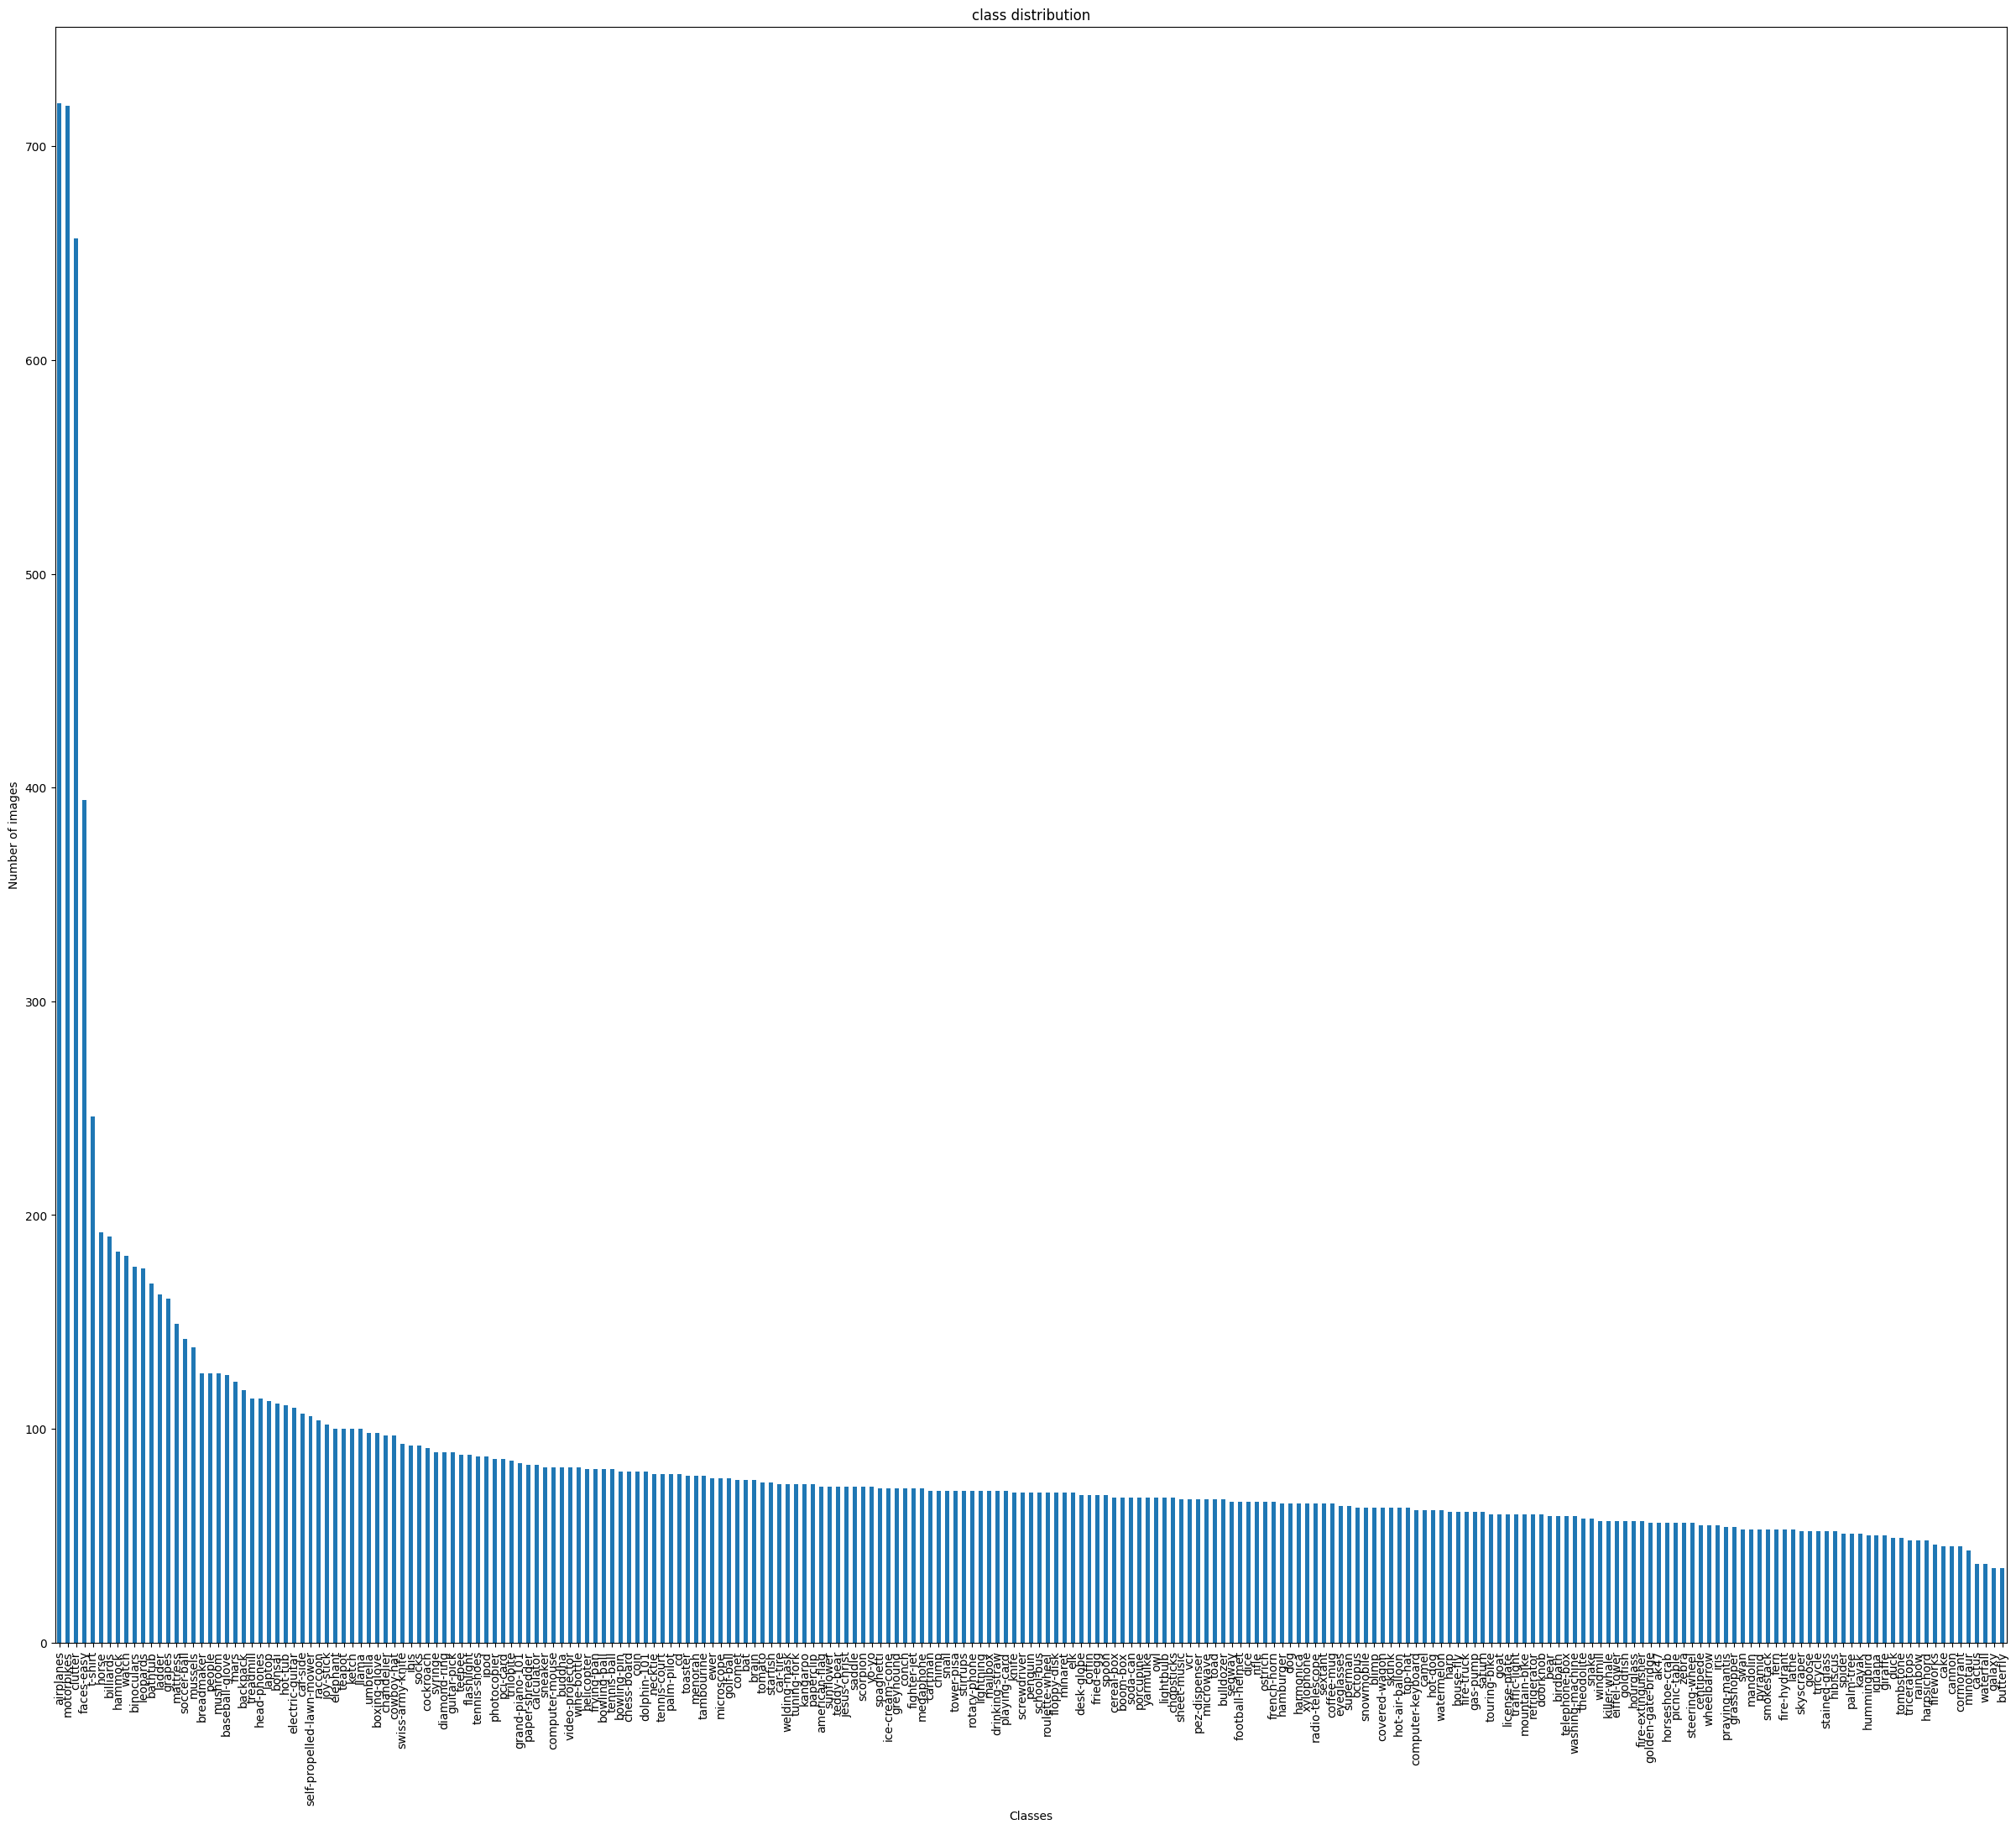

In [5]:
df['class_label'].value_counts().plot(kind='bar', figsize=(30,25))
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("class distribution")
plt.show()

### Check to see if the resize works and how it works<br>
This box will open an image on your PC, this way you can see if the resize worked and more precisely how it works.<br>
In this case the image will be a baseball glove, but you can change the index(1000) and see other images (obviously the index needs to be between 0 and 20130).<br>
The for loop just shows all index with their new size and channel, the output should be for 32x32: (32, 32, 3)


In [ ]:
arr = np.array(df.loc[1000, "images"])
img = Image.fromarray(arr.astype(np.uint8))
img.show()

for i, img in enumerate(df['images']):
   print(i, img.shape)

### SPLIT  (Dataset Preparation and Splitting)<br>

We prepare the dataset by encoding class labels and splitting the data into
training, validation, and test sets while preserving class distribution.<br>

The dataset is first divided into a training set and a held-out test set.<br>
The training set is then further split into training and validation subsets
to support model selection and hyperparameter tuning.<br>

The two prints give as output *Train size: 16104* and *Test size: 4026*.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X = np.stack(df['images'].values).astype(np.float32)

y = le.fit_transform(df['class_label']).astype('int32')

train_images, test_images, train_label, test_label = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 113,
    stratify = y
)

X_train_epoch, X_val_epoch, y_train_epoch, y_val_epoch = train_test_split(
    train_images, 
    train_label, 
    test_size = 0.2,
    stratify = train_label, 
    random_state = 113
    )

print("Train size:", len(train_images))
print("Test size:", len(test_images))

Train size: 16104
Test size: 4026


### LabelEncoder Sanity Check<br>

We verify the range and number of class labels in the training set to ensure
that label encoding has been applied correctly.<br>

In this box we will see the classes now written as numbers going from 0 to 232.

In [ ]:
print("min:", y_train_epoch.min())
print("max:", y_train_epoch.max())
print("num classi:", len(np.unique(y_train_epoch)))

### Dataset Preprocessing and Input Pipeline<br>

We build TensorFlow input pipelines for training, validation, and test sets.<br>
Images are normalized to the [0, 1] range and datasets are optimized using
batching, shuffling, and prefetching to improve training efficiency.

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(img, label):
    img = tf.clip_by_value(img, 0.0, 255.0) / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train_epoch, y_train_epoch)).shuffle(2048, seed=113)
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_epoch, y_val_epoch))
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_label))
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

### ANN imports<br>

We import the core Keras layers required to build the Artificial Neural Network,
including fully connected layers, activation functions, and regularization
components.


In [8]:
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, LeakyReLU

**ANN**<br>

An Artificial Neural Network (ANN) is used as a baseline model to perform
classification using flattened image features. Unlike CNNs, ANNs do not
explicitly exploit spatial information, making them useful for comparison
purposes.<br>

In this project, the ANN serves as a reference to evaluate how much performance
is gained by using convolutional architectures designed specifically for images.

### ANN Architecture<br>

We define an Artificial Neural Network (ANN) for image classification using
fully connected layers. Images are flattened before being processed, and
dropout is used to reduce overfitting.<br>
Is important to specify that the model takes images of shape 32x32, 3 channels; so be sure that you are using the correct images.

In [9]:
def ann_model_create(optimizer):
   model = Sequential()
   model.add(layers.Input(shape=(32,32,3)))
   model.add(Flatten())

   model.add(Dense(1024, kernel_initializer = 'uniform'))

   model.add(LeakyReLU(negative_slope= 0.05))

   model.add(Dropout(0.5))

   model.add(Dense(512, kernel_initializer = 'uniform'))

   model.add(LeakyReLU(negative_slope= 0.05))

   model.add(Dropout(0.5))

   model.add(Dense(233, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
   model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
   return model

### Model Evaluation Function<br>

We define a reusable evaluation function to assess model performance on the test
dataset and report loss and accuracy for a given optimizer.<br>
*print('OPTIMIZER USED: ', optimizer)* will print the optimizer used for the evaluation.<br>
*print("loss --> ", test_loss, "\naccuracy -->",test_acc)* will print the test loss and test accuracy for the evaluation.


In [ ]:
def model_evaluation(optimizer, model):
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print('OPTIMIZER USED: ', optimizer)
    print("Test loss --> ", test_loss, "\nTest accuracy -->",test_acc)
    return test_loss, test_acc

### Training Callbacks<br>

We define callbacks to improve the training process by preventing overfitting
and dynamically adjusting the learning rate based on validation performance.<br>
*print("Training stopped early due to EarlyStopping.")* is used so that if the training stops and it isn't because of an error than you know why.


In [11]:
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau

class EarlyStoppingCallback(Callback):
    def on_train_end(self, logs=None):
        print("Training stopped early due to EarlyStopping.")

early_stopping = EarlyStopping(monitor='val_loss',
    patience=13,
    min_delta=0.01,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

rp = ReduceLROnPlateau(
    monitor='val_loss',
    patience=13,
    mode='min',
    verbose=1,
    factor=0.2,
    min_lr=1e-5
)

## Optimizer Comparison Results<br>

We evaluate multiple optimizers to analyze their impact on training dynamics
and final classification performance of the ANN. Each optimizer is trained for
the same number of epochs and evaluated on the test set.<br>

### Observations<br>

- **FTRL** performs poorly, achieving accuracy below random guessing and
  failing to learn meaningful patterns. A similar behavior is observed with
  **Adadelta**, which performs slightly better but still remains ineffective.

- **Adagrad** shows a stable but limited learning behavior. It improves rapidly
  during the first epochs but quickly saturates, resulting in lower performance
  compared to Adam-based optimizers.

- **Adam** and **Nadam** exhibit similar training dynamics. Both start from a
  relatively higher accuracy but show noticeable oscillations during training,
  indicating less stable convergence.

- **RMSprop** follows a learning trend comparable to Adam and Nadam, but with
  significantly higher oscillations, suggesting reduced training stability.

- **SGD** and **Adamax** achieve the best overall performance. In particular,
  **Adamax** demonstrates faster and more controlled learning, resulting in the
  highest test accuracy among all tested optimizers.

### Test Set Performance Summary<br>

| Optimizer | Test Loss | Test Accuracy |
|----------|-----------|---------------|
| Adam     | 4.6286    | 0.1838 |
| SGD      | 4.1418    | 0.2027 |
| RMSprop  | 4.4882    | 0.1816 |
| Adadelta | 5.2010    | 0.0869 |
| Adagrad  | 4.6659    | 0.1364 |
| Adamax   | 4.0899    | **0.2317** |
| Nadam    | 4.6663    | 0.1846 |
| FTRL     | 5.4253    | 0.0358 |

### Conclusion<br>

Based on both training behavior and test accuracy, **Adamax** is selected as the
most effective optimizer for the ANN in this project, followed by **SGD**.<br>

### Output<br>

This box should show the training of the ANN with a bar filling up, above the bar the number of epochs done over the total and on the right there is the metrics we are focusing on being, the training and validation accuracy and loss. Above the first epoch, the optimizer used is printed.<br>

At the end the final accuracy and test loss are printed for every optimizer.<br>

At the end an image is going to be shown after all the ann have being trained and it shows: the training accuracy on the left and the validation accuracy on the right.

OPTIMIZER USED: adam ----
Epoch 1/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0569 - loss: 5.3108 - val_accuracy: 0.0959 - val_loss: 5.1310
Epoch 2/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0862 - loss: 5.1211 - val_accuracy: 0.1037 - val_loss: 4.9988
Epoch 3/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0924 - loss: 5.0355 - val_accuracy: 0.1115 - val_loss: 4.9041
Epoch 4/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1007 - loss: 4.9630 - val_accuracy: 0.1133 - val_loss: 4.8721
Epoch 5/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1053 - loss: 4.9111 - val_accuracy: 0.1223 - val_loss: 4.8625
Epoch 6/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1076 - loss: 4.8833 - val_accuracy: 0.1267 - val_loss: 4.7639
Epoch 7/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1121 - loss: 4.8553 - val_accuracy: 0.1279 - val_loss: 4.7849
Epoch 8/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1159

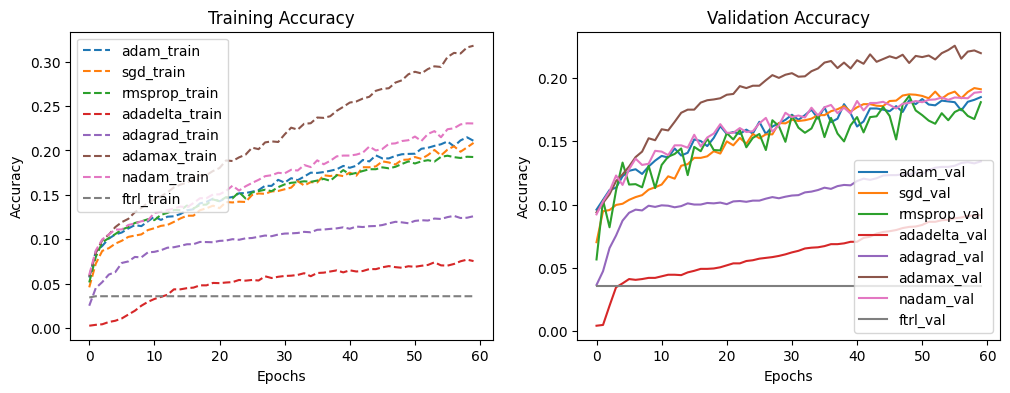

In [ ]:
'''
optimizers = ['adam', 'sgd', 'rmsprop', 'adadelta', 'adagrad','adamax','nadam','ftrl']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epoch = 60
results = []

for optimizer in optimizers:
   print(f'OPTIMIZER USED: {optimizer}','/'*20)
   
   model = ann_model_create(optimizer)
   
   history = model.fit(
       train_ds,
       epochs = epoch,
       validation_data = val_ds,
       verbose = 1
    )

   evaluate_result = model_evaluation(optimizer, model)
   
   # Check if the evaluation result is not None
   if evaluate_result is not None and len(evaluate_result) == 2:
        loss, accuracy = evaluate_result
        # Append information to the DataFrame
        results.append({'Optimizer':optimizer,'test_loss':loss,'test_accuracy':accuracy})
   else:
        print(f"Warning: Evaluation result for {optimizer} is None or has unexpected format.")

   # Plot training accuracy
   ax1.plot(history.history['accuracy'], label=f'{optimizer}_train', linestyle='--')
   ax1.set_title('Training Accuracy')
   ax1.set_xlabel('Epochs')
   ax1.set_ylabel('Accuracy')
   ax1.legend()

   # Plot validation accuracy
   ax2.plot(history.history['val_accuracy'], label=f'{optimizer}_val')
   ax2.set_title('Validation Accuracy')
   ax2.set_xlabel('Epochs')
   ax2.set_ylabel('Accuracy')
   ax2.legend()

optimizer_df = pd.DataFrame(results)
print(optimizer_df)
plt.show()
'''

### Final ANN Training with Selected Optimizer<br>

Based on the optimizer comparison, we train the ANN using **Adamax**, which showed
the best convergence behavior and highest test accuracy. Training is limited to
60 epochs, as performance was observed to plateau beyond this point.<br>

A learning rate scheduling callback is applied to improve convergence stability.<br>
The model is then evaluated on the test set to report final performance.<br>

If you want to save the weights of the ANN you can use *model.save_weights('best_ann_weights.h5')* (the file will be saved in the current directory) and just load it to use the ANN already trained to do some tests using this code:
 - model = ann_model_create(optimizer) #substitute the optimizer
 - model.load_weights('best_cnn_weights.h5')

In [ ]:
epoch = 60

optimizer = 'adamax'

model = ann_model_create(optimizer)

history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, verbose=1, callbacks=rp)

evaluate_result = model_evaluation(optimizer, model)

test_loss, test_acc = evaluate_result

#model.save_weights('best_ann_weights.h5')

Epoch 1/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0538 - loss: 5.3320 - val_accuracy: 0.0851 - val_loss: 5.1563 - learning_rate: 0.0010
Epoch 2/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0856 - loss: 5.1353 - val_accuracy: 0.1043 - val_loss: 5.0081 - learning_rate: 0.0010
Epoch 3/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0991 - loss: 5.0207 - val_accuracy: 0.1096 - val_loss: 4.9102 - learning_rate: 0.0010
Epoch 4/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1061 - loss: 4.9375 - val_accuracy: 0.1149 - val_loss: 4.8283 - learning_rate: 0.0010
Epoch 5/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1114 - loss: 4.8666 - val_accuracy: 0.1239 - val_loss: 4.7603 - learning_rate: 0.0010
Epoch 6/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1198 - loss: 4.7911 - val_accuracy: 0.1313 - val_loss: 4.6945 - learning_rate: 0.0010
Epoch 7/60
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1233 - loss: 4.

### ANN Training History Visualization<br>

We visualize the training and validation loss and accuracy across epochs
to analyze the learning behavior of the ANN and assess its convergence.<br>

The image is going to have: on the left the training loss and val loss and on the right the training accuracy and val accuracy.

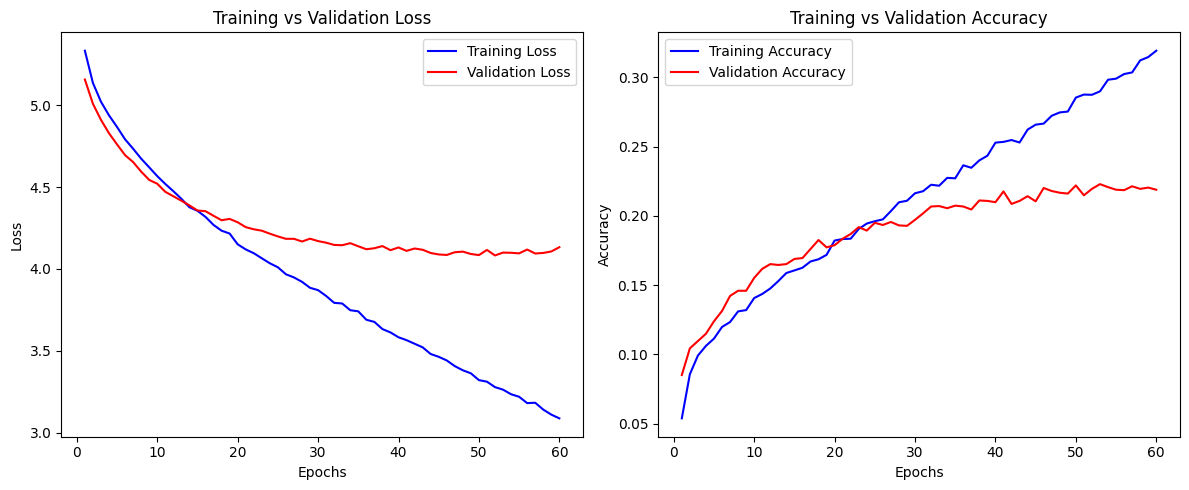

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

# Extract metrics
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### ANN Prediction<br>

We generate class probability predictions on the test set using the trained ANN
and convert them into discrete class labels.

In [19]:
y_pred_prob = model.predict(test_ds)
y_pred_ann = np.argmax(y_pred_prob, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Confusion Matrix (ANN)<br>

We compute the confusion matrix for the ANN predictions on the test set
to analyze class-level performance. The matrix can be visualized to
inspect misclassification patterns across classes.<br>

*class_names = le.classes_* is needed to show the names of the classes instead of the numbers given by the LabelEncoder.<br>

If you want you can remove the ''' to run the code, but having 233 classes the confution matrix won't be easy to read.

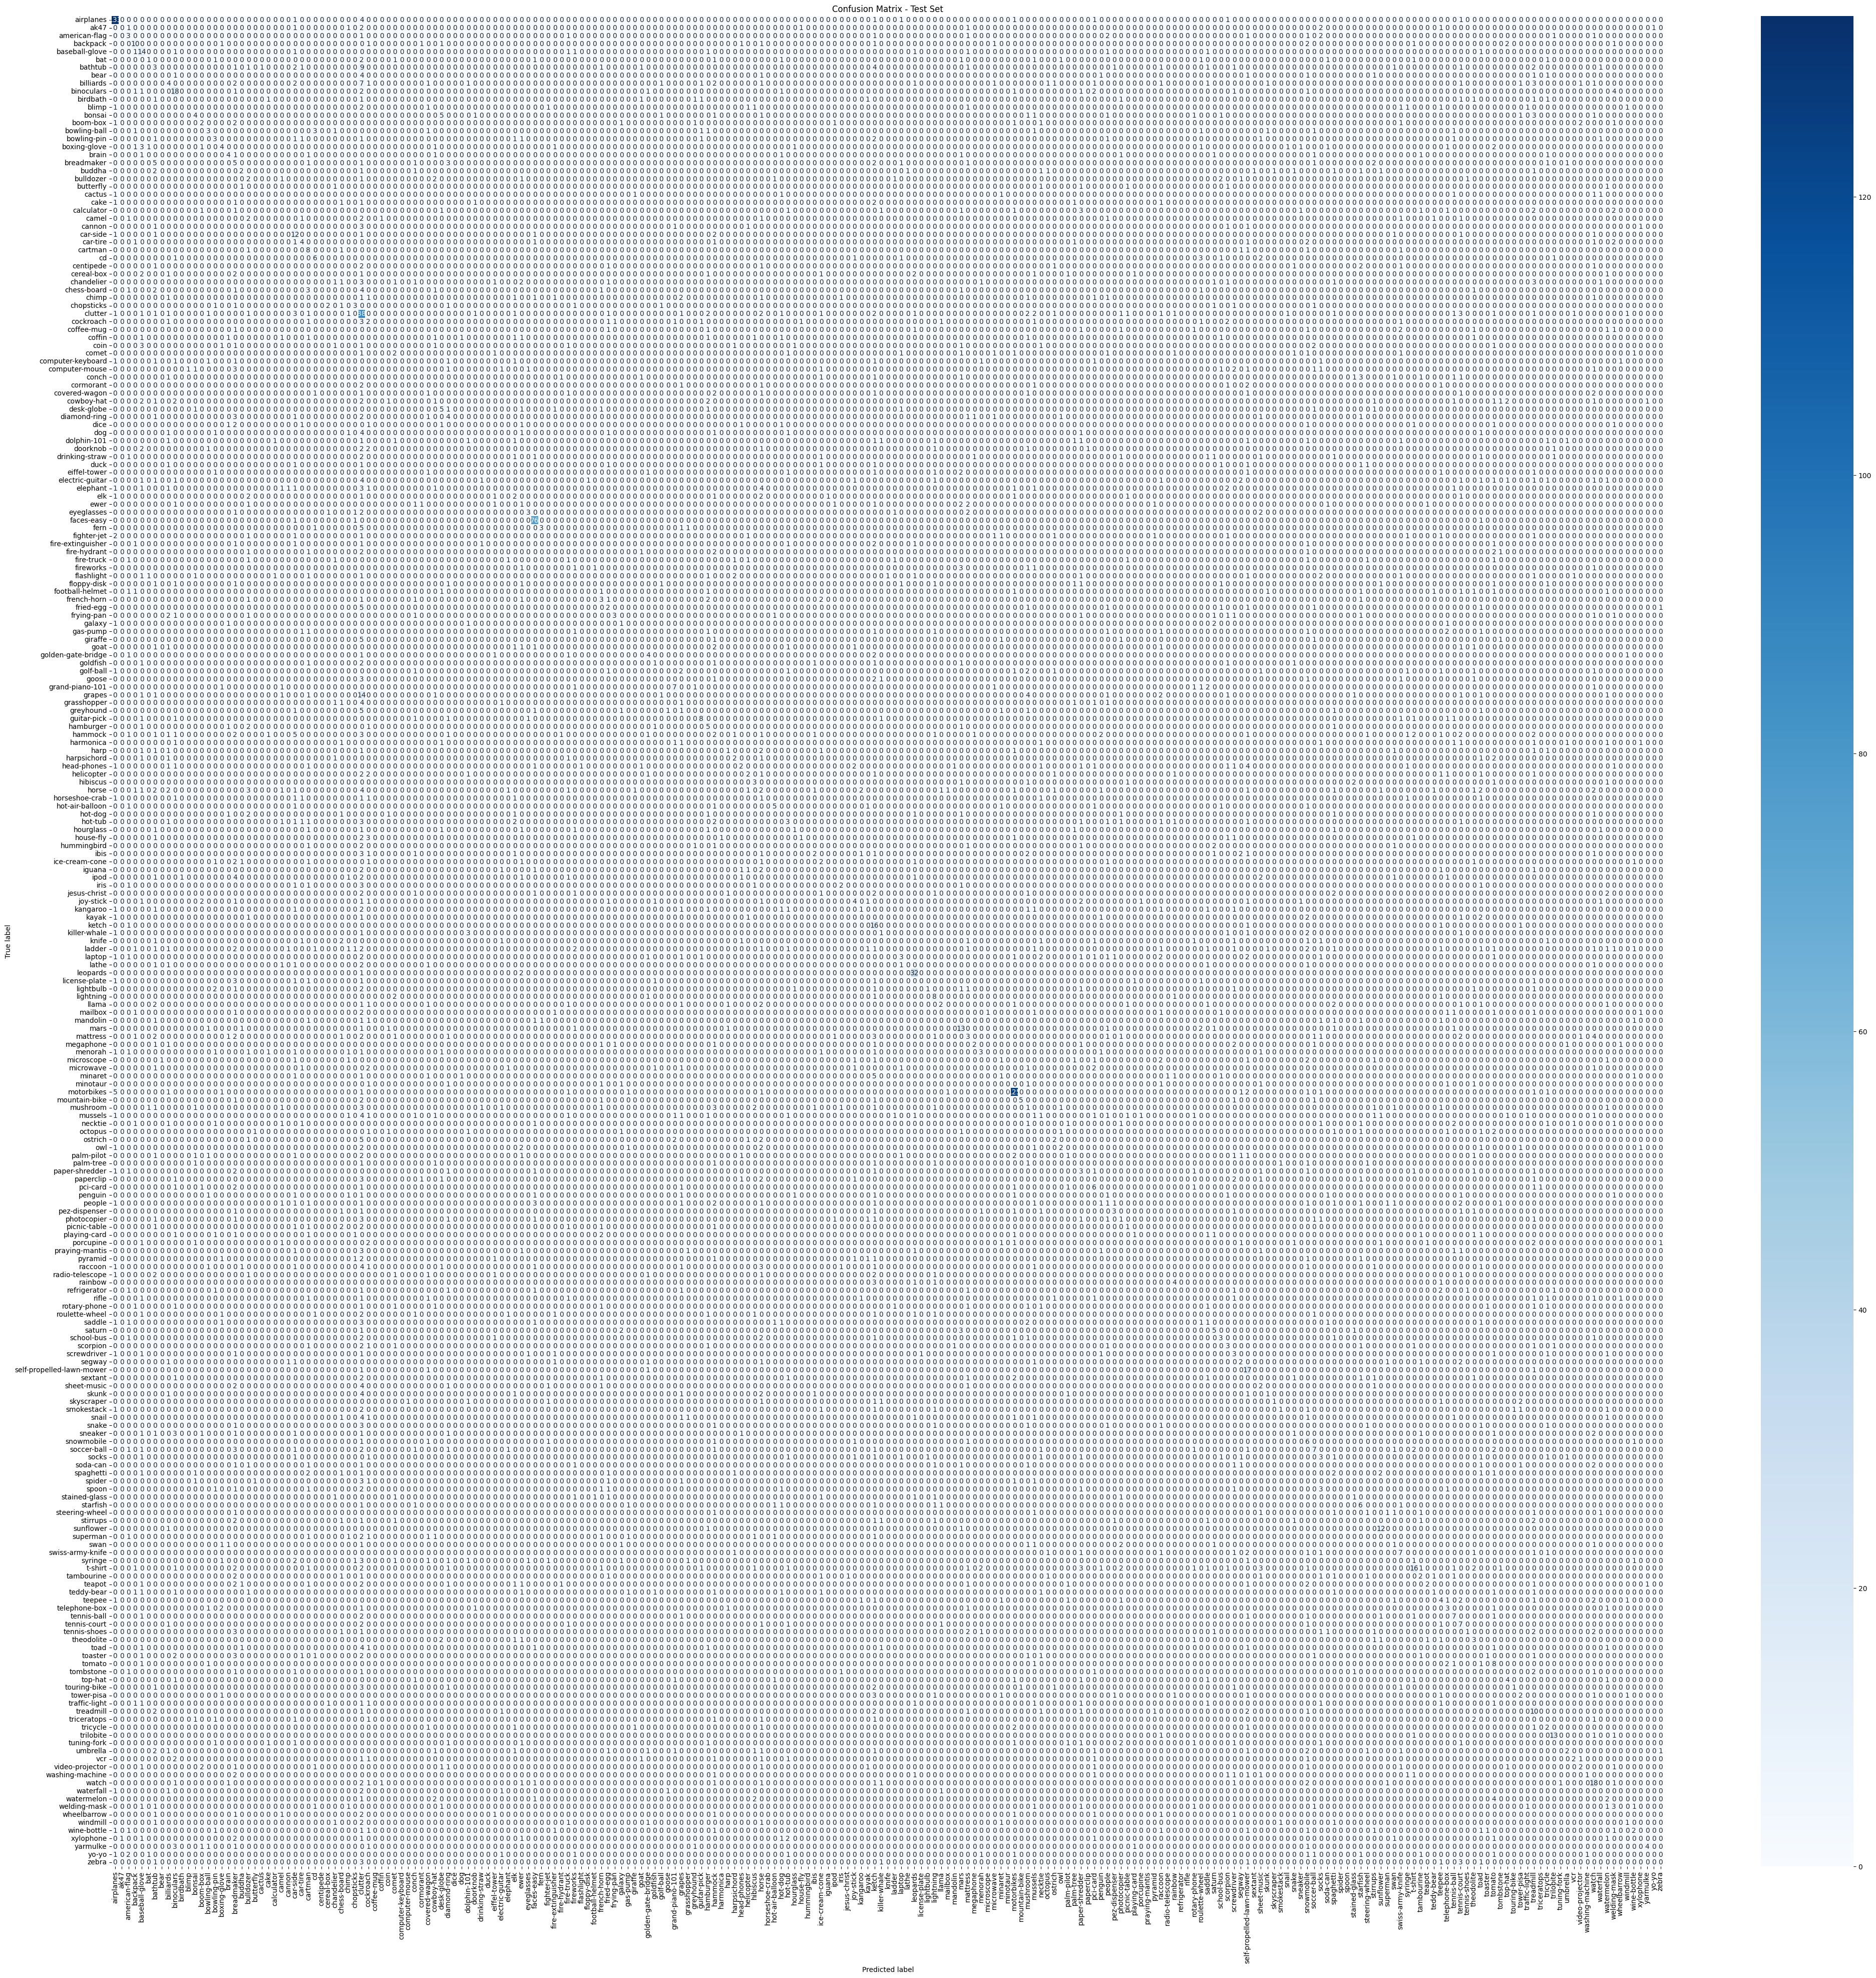

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = le.classes_

cm = confusion_matrix(test_label, y_pred_ann)
'''
plt.figure(figsize=(50,48))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Test Set")
plt.show()
'''

### Classification Report (ANN)<br>

We generate a classification report for the ANN on the test set, reporting
precision, recall, and F1-score for each class to summarize overall performance.

 - **Recall**: Out of all the truly positive instances. how many times did the model correctly identify as positive? (TPr)
 - **Precision**: Of all times the model predicted 'yes', how often was it correct?
 - **F1-score**: Tells you how well your model finds positive cases (recall) and how reliable those positive predictions are (precision).

Some of the classes will have 0 in all categories, because the model missclassified them every time they appeared.

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
class_names = le.classes_
print(classification_report(test_label, y_pred_ann, target_names=class_names))

                           precision    recall  f1-score   support

                airplanes       0.77      0.92      0.84       144
                     ak47       0.00      0.00      0.00        11
            american-flag       0.12      0.20      0.15        15
                 backpack       0.38      0.42      0.40        24
           baseball-glove       0.24      0.56      0.33        25
                      bat       0.20      0.07      0.10        15
                  bathtub       0.05      0.09      0.06        34
                     bear       0.00      0.00      0.00        12
                billiards       0.12      0.11      0.11        38
               binoculars       0.35      0.51      0.41        35
                 birdbath       0.00      0.00      0.00        12
                    blimp       0.00      0.00      0.00        13
                   bonsai       0.29      0.17      0.22        23
                 boom-box       0.18      0.14      0.16     

c:\Users\computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

### Error Analysis per Class (ANN)<br>

We compute the number of misclassified samples for each class by comparing
the total number of test samples with the correctly predicted ones.

In [ ]:
TP = np.diag(cm)
support = cm.sum(axis=1)

errors_per_class = support - TP

### Most Misclassified Classes (ANN)<br>

We identify the classes with the highest number of misclassified samples
to focus analysis on the most challenging categories for the ANN.

In [23]:
top_missclassified_images_ann = np.argsort(errors_per_class)[-20:][::-1]

### Mapping Class Indices to Labels (ANN)<br>

We convert the indices of the most misclassified classes into their
corresponding class names to improve interpretability.

In [24]:
top_class_names_ann = [class_names[c] for c in top_missclassified_images_ann]

### Detailed Error Summary for Most Misclassified Classes (ANN)<br>

We print, for each of the most misclassified classes, the number of errors
and the total number of test samples to better understand class-specific
performance issues.

In [ ]:
for c in top_missclassified_images_ann:
    print(
        f"{class_names[c]} --> errors = {errors_per_class[c]}, "
        f"support = {support[c]}"
    )

clutter --> errori = 43, support = 131
horse --> errori = 36, support = 38
hammock --> errori = 35, support = 37
billiards --> errori = 34, support = 38
ladder --> errori = 33, support = 33
t-shirt --> errori = 33, support = 49
grapes --> errori = 32, support = 32
bathtub --> errori = 31, support = 34
mattress --> errori = 27, support = 30
mussels --> errori = 27, support = 28
people --> errori = 24, support = 25
mushroom --> errori = 24, support = 25
electric-guitar --> errori = 22, support = 22
raccoon --> errori = 21, support = 21
soccer-ball --> errori = 21, support = 28
head-phones --> errori = 21, support = 23
laptop --> errori = 20, support = 23
elephant --> errori = 20, support = 20
breadmaker --> errori = 20, support = 25
bonsai --> errori = 19, support = 23


## Convolutional Neural Network (CNN)<br>

We define the building blocks required to construct a Convolutional Neural Network
used for image-based feature learning and classification.

### Model Components<br>

We import the core Keras layers used to build the CNN architecture, including
convolutional, pooling, normalization, and fully connected layers.

In [33]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout

### CNN  Architecture<br>

We define a Convolutional Neural Network (CNN) for image classification.
The model includes data augmentation, multiple convolutional blocks for feature extraction,
and fully connected layers for final classification.<br>

The architecture is designed to progressively learn higher-level visual features
while reducing spatial dimensionality.

In [34]:
def cnn_classifier_build(optimizer):
    classifier = Sequential()

    classifier.add(layers.Input(shape=(128,128,3)))

    classifier.add(layers.RandomFlip("horizontal"))
    classifier.add(layers.RandomRotation(0.1))
    classifier.add(layers.RandomZoom(0.1))

    classifier.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(BatchNormalization())

    classifier.add(layers.GlobalAveragePooling2D())

    classifier.add(Dense(256, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(233, activation='softmax'))

    classifier.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return classifier

### Model Initialization and Weight Loading<br>

We initialize the CNN classifier, build its architecture with the expected input
shape, and load pre-trained weights. The model summary is then displayed to verify
the final architecture.<br>

The *best_cnn_weights_acc45.h5* are going to be found in the image folders, put your path to the weigts file and use it or do as in the ANN and save new weights to use. 

In [36]:
optimizer = 'adam'
classifier = cnn_classifier_build(optimizer)
classifier.build((None, 128, 128, 3))
classifier.load_weights("C:\\Users\\computer\\Downloads\\best_cnn_weights_acc45.h5")

classifier.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 233)            │        59,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,746,025 (6.66 MB)

 Trainable params: 1,744,105 (6.65 MB)

 Non-trainable params: 1,920 (7.50 KB)

### CNN Training and Evaluation<br>

We train the CNN classifier using the training dataset and monitor performance
on a validation set. Early stopping and learning-rate scheduling callbacks are
used to improve convergence and prevent overfitting.<br>

After training, the model is evaluated on the test set to measure final
classification performance.<br>

Based on test performance: an accuracy on the test data of 45% is reachable using this model.

In [ ]:
epoch_cnn = 100
optimizer = 'adam'
classifier = cnn_classifier_build(optimizer)

history_cnn = classifier.fit(
    train_ds,
    epochs = epoch_cnn,
    validation_data = val_ds,
    verbose = 1,
    callbacks=[early_stopping, rp],
)

evaluate_result = model_evaluation(optimizer, classifier)
test_loss, test_acc = evaluate_result
#classifier.save_weights('best_cnn_weights.h5')

### Training History Visualization<br>

We visualize the training and validation loss and accuracy across epochs
to analyze the learning behavior of the CNN and detect potential overfitting
or underfitting. 

In [ ]:
history_cnn_dict = history_cnn.history

# Extract metrics
cnn_train_loss = history_cnn_dict['loss']
cnn_val_loss = history_cnn_dict['val_loss']
cnn_train_acc = history_cnn_dict['accuracy']
cnn_val_acc = history_cnn_dict['val_accuracy']

epochs = range(1, len(cnn_train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, cnn_train_loss, 'b-', label='Training Loss')
plt.plot(epochs, cnn_val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, cnn_train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, cnn_val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### CNN Prediction<br>

We generate class probability predictions on the test set using the trained CNN
and convert them into discrete class labels.

In [49]:
y_pred_prob_cnn = classifier.predict(test_ds)
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step


### Confusion Matrix<br>

We compute and visualize the confusion matrix on the test set to analyze
the classification performance of the CNN across all classes.<br> 
As for the ANN you can choose to see the confution matrix, but it will be difficult to read.

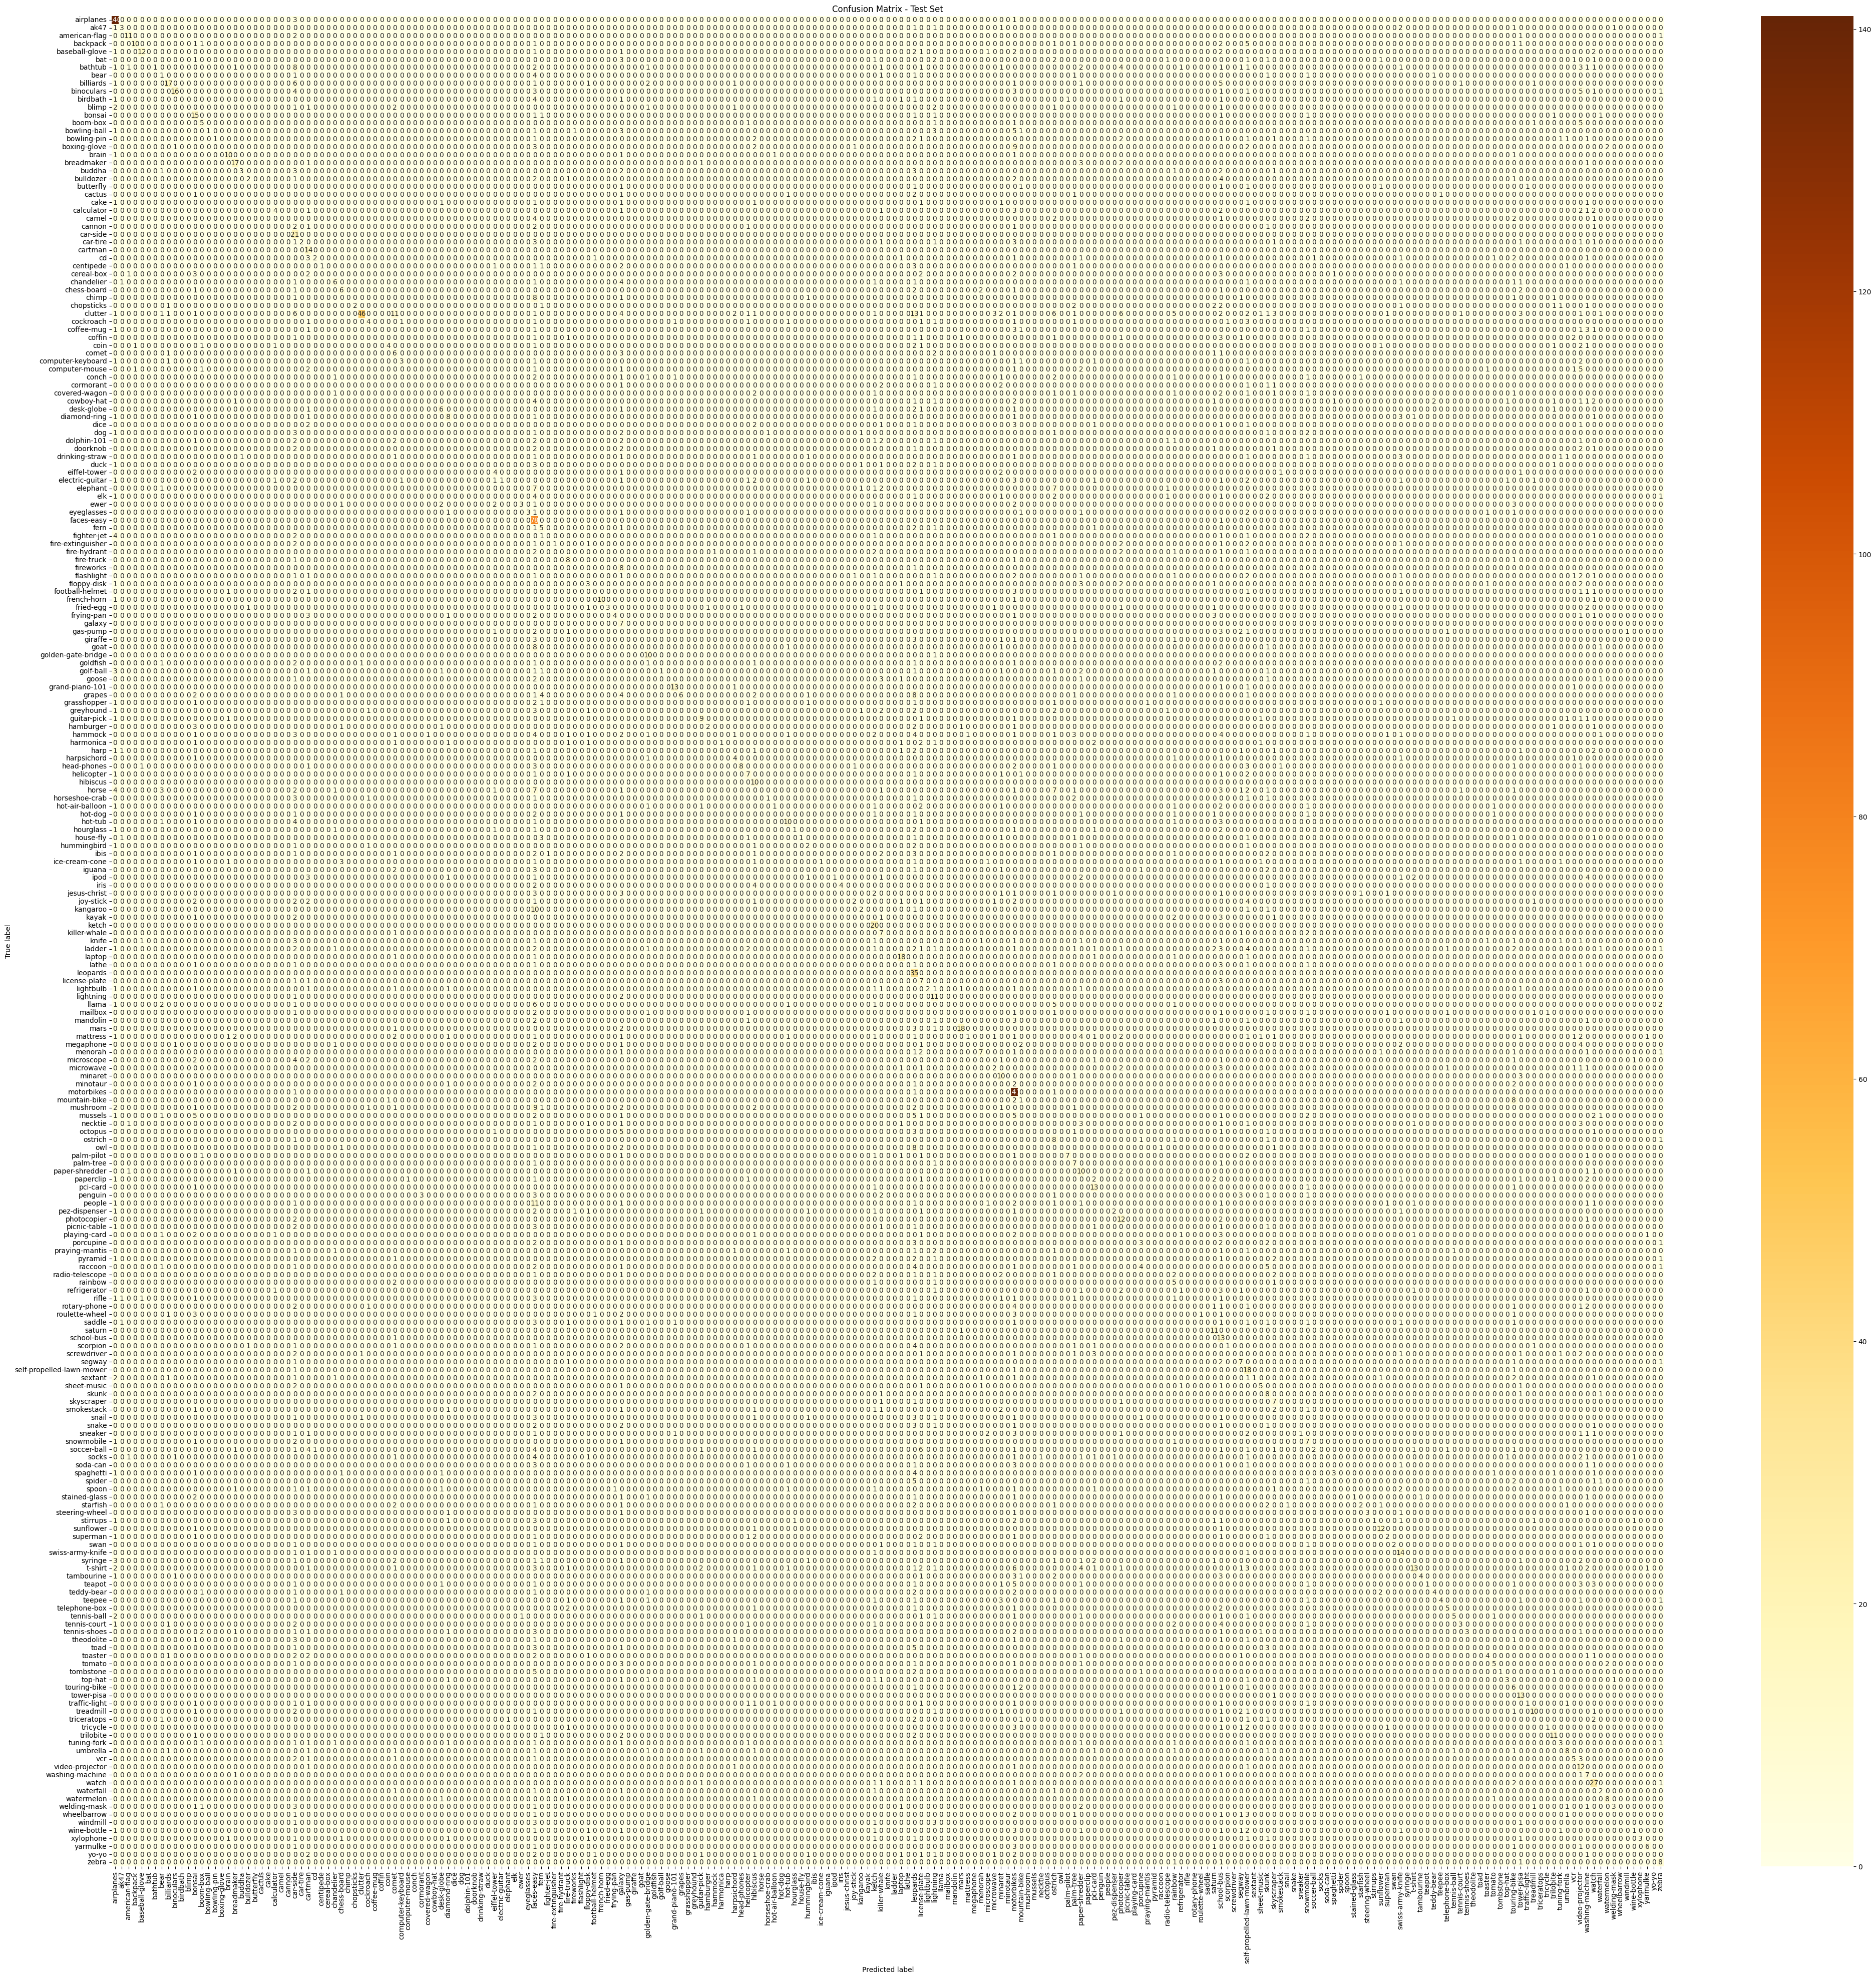

In [ ]:
from sklearn.metrics import confusion_matrix
'''
cm_cnn= confusion_matrix(test_label, y_pred_cnn)

plt.figure(figsize=(50,48))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt="d",
    cmap="YlOrBr",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Test Set")
plt.show()
'''

### Error Analysis per Class<br>

We compute the number of misclassified samples for each class by comparing
the total number of test samples with the correctly predicted ones.

In [ ]:
cm_cnn = confusion_matrix(test_label, y_pred_cnn)
TP = np.diag(cm_cnn)
support = cm_cnn.sum(axis=1)

errors_per_class = support - TP

[140   3  11  10  12   0   1   1  17  16   0   0  15   5   1   1   0  10
  17   3   2   0   0   0   4   0   0  21   2  14   2   1   0   6   6   0
   2  46   4   0   0   4   6   3   0   0   0   0   0   6   8   0   0   0
   0   0   0   4   1   0   0   3   3  78   5   0   1   0   8   0   0   3
   0  10   3   4   7   0   0   0  10   0   1   0  13   6   0   0   9   2
   0   1   0   4   8   7  10   0   1   1   0  10   1   1   2   0   1   0
   1   4   0   2   2   0  20   7   0   0  18   0  35   7   2  11   0   0
   0  18   1   0   7   0   2  10   0 141   1   0   0   0   0   8   0   7
   7  10   0  13   0   0   2  12   0   0   3   0   0   0   0   5   1   0
   0   1   0  11  13   1   0   7  18   1   5   8   7   0   0   0   1   7
   2   0   0   3   0   0   1   2   3   1  12   2   2  14   0  13   4   1
   4   4   5   5   3   3   0   0   4   5   1   3   6  13   1  10   0   1
  11   3   8   5  12   7  27   2   8   3   0   0   1   3   6   0   8]


### Most Misclassified Classes

We identify the classes with the highest number of misclassified samples
to focus further analysis on the most problematic categories.

In [53]:
top_missclassified_images_cnn = np.argsort(errors_per_class)[-20:][::-1]

### Mapping Class Indices to Labels<br>

We convert the indices of the most misclassified classes into their
corresponding class names for easier interpretation.

In [54]:
top_class_names_cnn = [class_names[c] for c in top_missclassified_images_cnn]

### Detailed Error Summary for Most Misclassified Classes (CNN)<br>

We print, for each of the most misclassified classes, the number of errors
and the total number of test samples to better understand class-specific
performance issues.

In [ ]:
for c in top_missclassified_images_cnn:
    print(
        f"{class_names[c]} --> errors = {errors_per_class[c]}, "
        f"support = {support[c]}"
    )

clutter --> errori = 85, support = 131
horse --> errori = 38, support = 38
hammock --> errori = 37, support = 37
t-shirt --> errori = 36, support = 49
ladder --> errori = 33, support = 33
bathtub --> errori = 33, support = 34
mattress --> errori = 29, support = 30
mussels --> errori = 28, support = 28
soccer-ball --> errori = 26, support = 28
grapes --> errori = 26, support = 32
people --> errori = 25, support = 25
mushroom --> errori = 25, support = 25
electric-guitar --> errori = 21, support = 22
billiards --> errori = 21, support = 38
raccoon --> errori = 21, support = 21
elephant --> errori = 20, support = 20
llama --> errori = 20, support = 20
boxing-glove --> errori = 20, support = 20
binoculars --> errori = 19, support = 35
teapot --> errori = 19, support = 20


### Classification Report<br>

We generate a classification report on the test set, providing precision,
recall, and F1-score for each class to summarize the overall performance
of the CNN.

 - **Recall**: Out of all the truly positive instances. how many times did the model correctly identify as positive? (TPr)
 - **Precision**: Of all times the model predicted 'yes', how often was it correct?
 - **F1-score**: Tells you how well your model finds positive cases (recall) and how reliable those positive predictions are (precision).


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_label, y_pred_cnn, target_names=class_names))

                           precision    recall  f1-score   support

                airplanes       0.67      0.97      0.80       144
                     ak47       0.38      0.27      0.32        11
            american-flag       0.69      0.73      0.71        15
                 backpack       0.83      0.42      0.56        24
           baseball-glove       0.80      0.48      0.60        25
                      bat       0.00      0.00      0.00        15
                  bathtub       1.00      0.03      0.06        34
                     bear       0.06      0.08      0.07        12
                billiards       0.65      0.45      0.53        38
               binoculars       0.80      0.46      0.58        35
                 birdbath       0.00      0.00      0.00        12
                    blimp       0.00      0.00      0.00        13
                   bonsai       0.21      0.65      0.31        23
                 boom-box       0.36      0.36      0.36     

c:\Users\computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\computer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

**CLUSTERING**<br>

Clustering is used to explore the structure of the data without relying on labels.
By grouping samples based on visual similarity, we can uncover hidden patterns,
natural groupings, and potential ambiguities in the dataset.<br>

In this project, clustering is applied to **feature representations extracted
from a trained CNN**, rather than raw images. This is important because learned
features capture high-level semantic information, making similarity comparisons
more meaningful.

### Feature Extraction Model<br>

This model reuses the trained `classifier` network to extract high-level feature representations instead of final class predictions.

- **Input:** Same input tensor as the original classifier  
- **Output:** Activations from the `Dense(256)` layer (`layers[-3]`)  
- **Purpose:** Generate a 256-dimensional feature embedding for each input sample  

This approach is commonly used for:
- Transfer learning
- Clustering and similarity analysis
- Downstream machine learning tasks
- Representation learning and visualization

In [ ]:
from tensorflow.keras.models import Model

feature_extractor = Model(
    inputs=classifier.inputs,
    outputs=classifier.layers[-3].output
)

### Feature Extraction

We define a feature extractor from the trained classifier by outputting an intermediate
Dense layer. The extracted features will be used as input for the clustering step.

In [58]:
feature_extractor.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686,144 (6.43 MB)

 Trainable params: 1,684,224 (6.42 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Feature Extraction<br>

We use the feature extractor to compute feature vectors for each input image.
The output consists of high-level representations that will be used for clustering.

In [ ]:
X = X / 255
features = feature_extractor.predict(X, batch_size=32)
print(features.shape)

630/630 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step
(20130, 256)


### Feature Normalization and Dimensionality Reduction<br>

We standardize the extracted features to ensure zero mean and unit variance,
then apply Principal Component Analysis (PCA) to reduce dimensionality.<br>

This step:
- Improves numerical stability
- Reduces noise and redundancy
- Makes clustering more efficient and interpretable

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = StandardScaler().fit_transform(features)

pca = PCA(n_components=64)
features_pca = pca.fit_transform(features)


### Density-Based Clustering<br>

We apply HDBSCAN to cluster the feature representations in the reduced PCA space.<br>
This algorithm automatically detects the number of clusters and identifies noise points.<br>
HDBSCAN was chosen because it is a clustering model that works pretty well with unbalanced datasets.

In [61]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    metric='euclidean'
)
clusters = clusterer.fit_predict(features_pca)

### Cluster Count<br>

We compute the number of detected clusters by excluding noise points
(label `-1`) identified by HDBSCAN.

In [ ]:
unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters[unique_clusters != -1])

print("Numero di cluster:", num_clusters)

Numero di cluster: 2


### Clustering Quality Evaluation<br>

We compute the Silhouette Score to evaluate the quality of the clustering,
measuring how well samples fit within their assigned clusters.

In [63]:
from sklearn.metrics import silhouette_score

sil = silhouette_score(features_pca, clusters)
print(sil)

0.0997634008526802


### Silhouette Analysis per Cluster<br>

We compute the Silhouette coefficient for each individual sample and visualize
the distribution of scores per cluster using a silhouette plot.<br>

This visualization:
- Shows how well-separated each cluster is
- Highlights the presence of overlapping clusters
- Explicitly includes noise points (`-1`) detected by HDBSCAN

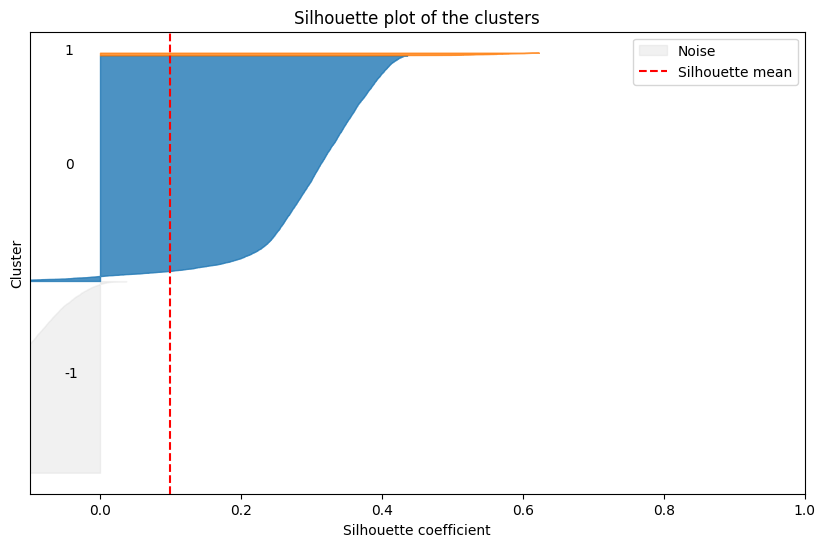

In [ ]:
from sklearn.metrics import silhouette_samples

sil_samples = silhouette_samples(features_pca, clusters)

cluster_labels = np.unique(clusters)

cluster_colors = {
    0: "#1f77b4",
    1: "#ff7f0e",
}

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

for c in cluster_labels:
    ith_cluster_silhouette_values = sil_samples[clusters == c]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    if c == -1:
        color = "lightgrey"
        alpha = 0.3
        label = "Noise"
    else:
        color = cluster_colors[c]
        alpha = 0.8
        label = f"Cluster {c}"

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=alpha,
        label=label if c == -1 else ""
    )

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(c))
    y_lower = y_upper + 10

sil = np.mean(sil_samples)
ax.axvline(x=sil, color="red", linestyle="--", label="Silhouette mean")

ax.set_title("Silhouette plot of the clusters")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Cluster")
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.legend()

plt.show()

### 2D Visualization with t-SNE<br>

We apply t-SNE to project the high-dimensional feature representations into
two dimensions for visualization purposes. Points are colored according to
their cluster assignment

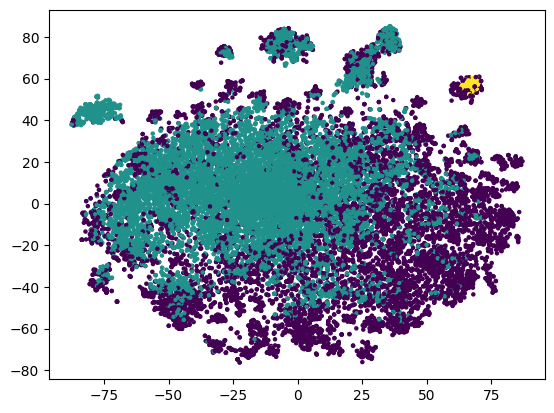

In [67]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)
X_2d = tsne.fit_transform(features_pca)

plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, s=5)
plt.show()


### t-SNE Visualization by Cluster<br>

We visualize the 2D t-SNE projection by plotting each cluster separately,
assigning distinct colors to valid clusters and a dedicated color to noise
points (`-1`) for clearer interpretation (the noise is going to be identified with black).

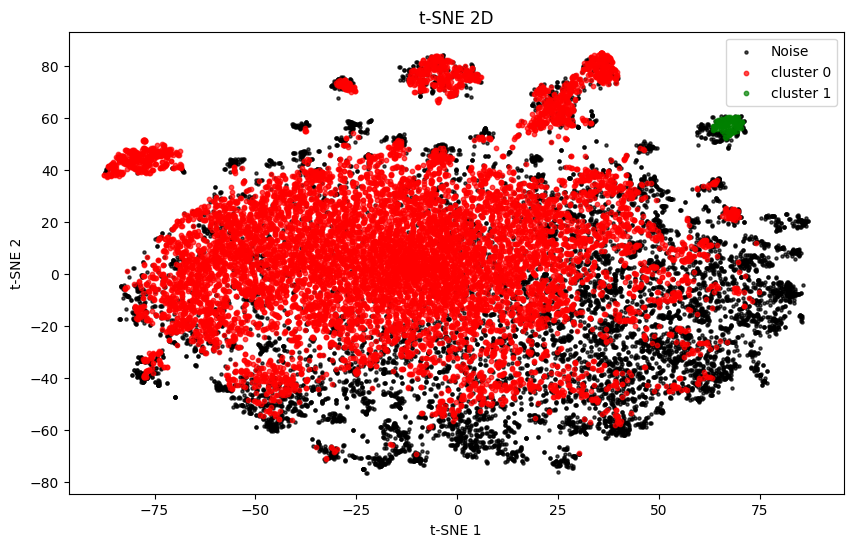

In [ ]:
unique_clusters = np.unique(clusters)

plt.figure(figsize=(10, 6))

for i, c in enumerate(unique_clusters):
    cluster_points = X_2d[clusters == c]
    
    if c == -1:
        color = "black"
        label = "Noise"
        size = 5
    elif c == 0:
        color = 'red'
        label = 'cluster 0'
        size = 10
    else:
        color = 'green'
        label = 'cluster 1'
        size = 10
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=color, s=size, label=label, alpha=0.7)

plt.title("t-SNE 2D")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()